In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pickle
import joblib

In [2]:
def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # all the special characters and numbers will be removed
    return text.strip()  


def train_evaluate_model(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    # Train model
    model.fit(X_train, y_train)

    # Predict on validation set
    val_predictions = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    val_classification_report = classification_report(y_val, val_predictions)
    val_conf_matrix = confusion_matrix(y_val, val_predictions)

    print(f'Validation Accuracy ({model_name}): {val_accuracy:.4f}')
    print(f'Classification Report on Validation Set ({model_name}):')
    print(val_classification_report)
    print(f'Confusion Matrix on Validation Set ({model_name}):')
    print(val_conf_matrix)

    # Predict on test set
    test_predictions = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_classification_report = classification_report(y_test, test_predictions)
    test_conf_matrix = confusion_matrix(y_test, test_predictions)

    print(f'Test Accuracy ({model_name}): {test_accuracy:.4f}')
    print(f'Classification Report on Test Set ({model_name}):')
    print(test_classification_report)
    print(f'Confusion Matrix on Test Set ({model_name}):')
    print(test_conf_matrix)

    return test_accuracy

In [3]:
try:
    df = pd.read_csv("data2.csv")
except pd.errors.ParserError as e:
    print(f"Error parsing CSV: {e}")
    exit(1)

# Drop 'Class' column if it exists
if 'Class' in df.columns:
    df.drop(columns=['Class'], inplace=True)

# Extract text data and labels
text_data = df['tweet'].tolist()
labels = df['class'].tolist()

# Preprocessing and TF-IDF Vectorization
preprocessor = FunctionTransformer(lambda x: [preprocess_text(text) for text in x])
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('tfidf', tfidf_vectorizer)
])

# Fit-transform the pipeline on the text data
try:
    tfidf_matrix = pipeline.fit_transform(text_data)
except Exception as e:
    print(f"Error in pipeline fit-transform: {e}")
    exit(1)

In [4]:
try:
    with open('tfidf1_vectorizer.pkl', 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)
    print("TF-IDF Vectorizer saved to tfidf_vectorizer.pkl")
except Exception as e:
    print(f"Error saving TF-IDF Vectorizer: {e}")
    exit(1)

TF-IDF Vectorizer saved to tfidf_vectorizer.pkl


In [5]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(tfidf_matrix, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
rf_classifier = RandomForestClassifier(random_state=42)
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
svm_classifier = SVC(random_state=42)
dt_classifier = DecisionTreeClassifier(random_state=42)

In [7]:
rf_accuracy = train_evaluate_model(rf_classifier, 'Random Forest', X_train, y_train, X_val, y_val, X_test, y_test)
lr_accuracy = train_evaluate_model(lr_classifier, 'Logistic Regression', X_train, y_train, X_val, y_val, X_test, y_test)
svm_accuracy = train_evaluate_model(svm_classifier, 'SVM', X_train, y_train, X_val, y_val, X_test, y_test)
dt_accuracy = train_evaluate_model(dt_classifier, 'Decision Tree', X_train, y_train, X_val, y_val, X_test, y_test)

Validation Accuracy (Random Forest): 0.8857
Classification Report on Validation Set (Random Forest):
              precision    recall  f1-score   support

           0       0.53      0.09      0.16       220
           1       0.91      0.96      0.93      2867
           2       0.79      0.82      0.81       630

    accuracy                           0.89      3717
   macro avg       0.74      0.62      0.63      3717
weighted avg       0.87      0.89      0.87      3717

Confusion Matrix on Validation Set (Random Forest):
[[  20  161   39]
 [  18 2753   96]
 [   0  111  519]]
Test Accuracy (Random Forest): 0.8822
Classification Report on Test Set (Random Forest):
              precision    recall  f1-score   support

           0       0.46      0.12      0.19       207
           1       0.90      0.96      0.93      2880
           2       0.81      0.79      0.80       631

    accuracy                           0.88      3718
   macro avg       0.72      0.62      0.64      3

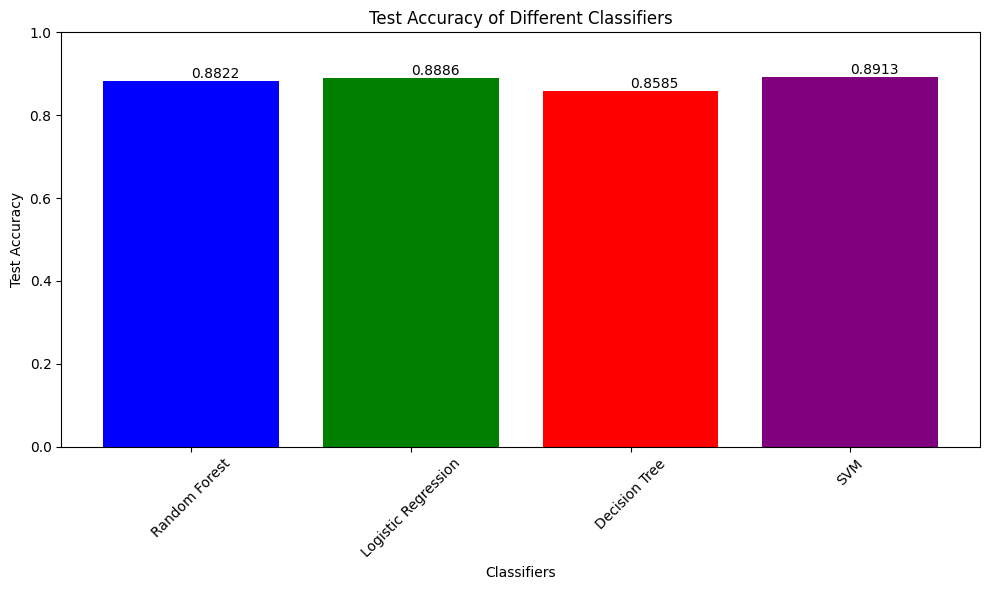

In [8]:
classifiers = ['Random Forest', 'Logistic Regression', 'Decision Tree', 'SVM']
accuracies = [rf_accuracy, lr_accuracy, dt_accuracy,  svm_accuracy]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, accuracies, color=['blue', 'green', 'red', 'purple'])

# Adding labels and title
plt.xlabel('Classifiers')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy of Different Classifiers')
plt.ylim([0.0, 1.0])  # Setting y-axis limit to better visualize differences
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Adding the actual value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

In [9]:
best_model = svm_classifier
try:
    joblib.dump(best_model, "xgb_classifier.joblib")
    print("XGBoost Classifier saved to xgb_classifier.joblib")
except Exception as e:
    print(f"Error saving XGBoost Classifier: {e}")
    exit(1)

XGBoost Classifier saved to xgb_classifier.joblib


In [ ]:

loaded_model = joblib.load("xgb_classifier.joblib")
with open('tfidf_vectorizer.pkl', 'rb') as f:
    loaded_tfidf_vectorizer = pickle.load(f)

class_labels = {0: 'Offensive Language', 1: 'Hate Speech', 2: 'non hate speech'}

def classify_text(text):
    # Transform the input data using the loaded TF-IDF vectorizer
    input_transformed = loaded_tfidf_vectorizer.transform([text])

    # Make prediction
    prediction = loaded_model.predict(input_transformed)

    # Get the predicted class label
    predicted_class = class_labels[prediction[0]]
    return predicted_class

if __name__ == "__main__":
    # Ask for user input
    input_text = input("Enter text to classify: ")
    
    # Classify the input text
    predicted_class = classify_text(input_text)
    
    # Print the classification result
    print(f"Input: {input_text} -> Prediction: {predicted_class}")